# System availability example

This notebook shows example usage of the inverter availability functions.  As with the degradation and soiling example, we recommend installing the specific versions of packages used to develop this notebook. This can be achieved in your environment by running `pip install -r requirements.txt` followed by `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

RdTools currently implements two methods of quantifying system availability.  The first method compares power measurements from inverters and the system meter to distinguish subsystem communication interruptions from true outage events.  The second method determines the uncertainty bounds around an energy estimate of a total system outage and compares with true production calculated from a meter's cumulative production measurements.  The RdTools `AvailabilityAnalysis` class uses both methods to quantify downtime loss.

These methods are described in K. Anderson and R. Blumenthal, "Overcoming Communications Outages in Inverter Downtime Analysis", 2020 IEEE 47th Photovoltaic Specialists Conference (PVSC).

In [1]:
import rdtools
import pvlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Quantifying the production impact of inverter downtime events is complicated by gaps in a system's historical data caused by communication interruptions.  Although communication interruptions may prevent remote operation, they usually do not result in production loss.  Accurate production loss estimates require the ability to distinguish true outages from communication interruptions.

The first method focuses on partial outages where some of a system's inverters are reporting production and some are not.  In these cases, the method examines the AC power measurements at the inverter and system meter level to classify each timestamp individually and estimate timeseries production loss.  This level of granularity is made possible by comparing timeseries power measurements between inverters and the meter.

First we'll generate a test dataset to demonstrate the method. This code block just puts together an artificial dataset to use for the analysis -- feel free to skip ahead to where it gets plotted.

In [2]:
def make_dataset():
    """
    Make an example dataset with several types of data outages for availability analysis.
    
    Returns
    -------
    df_reported : pd.DataFrame
        Simulated data as a data acquisition system would report it, including the
        effect of communication interruptions.
    df_secret : pd.DataFrame
        The secret true data of the system, not affected by communication
        interruptions.  Only used for comparison with the analysis output.
    expected_power : pd.Series
        An "expected" power signal for this hypothetical PV system, simulating a
        modeled power from satellite weather data or some other method.
    """

    # generate a plausible clear-sky power signal
    times = pd.date_range('2019-01-01', '2019-01-12', freq='15min', tz='US/Eastern',
                          closed='left')
    location = pvlib.location.Location(40, -80)
    clearsky = location.get_clearsky(times, model='haurwitz')
    # just scale GHI to power for simplicity
    base_power = 2.5*clearsky['ghi']
    # but require a minimum irradiance to turn on, simulating start-up voltage
    base_power[clearsky['ghi'] < 20] = 0

    df_secret = pd.DataFrame({
        'inv1_power': base_power,
        'inv2_power': base_power * 1.5,
        'inv3_power': base_power * 0.66,
    })

    # set the expected_power to be pretty close to actual power,
    # but with some autocorrelated noise and a bias:
    expected_power = df_secret.sum(axis=1)
    np.random.seed(2020)
    N = len(times)
    expected_power *= 0.9 - (0.3 * np.sin(np.arange(0, N)/7 +
                             np.random.normal(0, 0.2, size=N)))

    # Add a few days of individual inverter outages:
    df_secret.loc['2019-01-03':'2019-01-05', 'inv2_power'] = 0
    df_secret.loc['2019-01-02', 'inv3_power'] = 0
    df_secret.loc['2019-01-07 00:00':'2019-01-07 12:00', 'inv1_power'] = 0

    # and a full system outage:
    full_outage_date = '2019-01-08'
    df_secret.loc[full_outage_date, :] = 0

    # calculate the system meter power and cumulative production, 
    # including the effect of the outages:
    df_secret['meter_power'] = df_secret.sum(axis=1)
    interval_energy = rdtools.energy_from_power(df_secret['meter_power'])
    df_secret['meter_energy'] = interval_energy.cumsum()
    # fill the first NaN from the cumsum with 0
    df_secret['meter_energy'] = df_secret['meter_energy'].fillna(0)
    # add an offset to reflect previous production:
    df_secret['meter_energy'] += 5e5

    # now that the "true" data is in place, let's add some communications interruptions:
    df_reported = df_secret.copy()
    # in full outages, we lose all the data:
    df_reported.loc[full_outage_date, :] = np.nan
    # add a communications interruption that overlaps with an inverter outage:
    df_reported.loc['2019-01-05':'2019-01-06', 'inv1_power'] = np.nan
    # and a communication outage that affects everything:
    df_reported.loc['2019-01-10', :] = np.nan

    return df_reported, df_secret, expected_power

Let's visualize the dataset before analyzing it with RdTools.  The dotted lines show the "true" data that wasn't recorded by the datalogger because of interrupted communications.

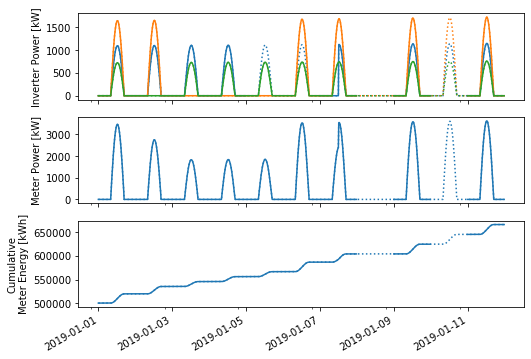

In [3]:
df, df_secret, expected_power = make_dataset()

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

# inverter power
df_secret[['inv1_power', 'inv2_power', 'inv3_power']].plot(ax=axes[0],
                                                           legend=False, ls=':',
                                                           color=colors)
df[['inv1_power', 'inv2_power', 'inv3_power']].plot(ax=axes[0], legend=False)
# meter power
df_secret['meter_power'].plot(ax=axes[1], ls=':', color=colors[0])
df['meter_power'].plot(ax=axes[1])
# meter cumulative energy
df_secret['meter_energy'].plot(ax=axes[2], ls=':', color=colors[0])
df['meter_energy'].plot(ax=axes[2])

axes[0].set_ylabel('Inverter Power [kW]')
axes[1].set_ylabel('Meter Power [kW]')
axes[2].set_ylabel('Cumulative\nMeter Energy [kWh]')
plt.show()

Note that the solid lines show the data that would be available in our example while the dotted lines show the true underlying behavior that we normally wouldn't know.

If we hadn't created this dataset ourselves, it wouldn't necessarily be obvious why the meter shows low or no production on some days -- maybe it was just cloudy weather, maybe it was a nuisance communication outage (broken cell modem power supply, for example), or maybe it was a true power outage.  This example also shows how an inverter can appear to be offline while actually producing normally.  For example, just looking at inverter power on the 5th, it appears that only the small inverter is producing.  However, the meter shows two inverters' worth of production.  Similarly, the 6th shows full meter production despite one inverter not reporting power.  Using only the inverter-reported power would overestimate the production loss because of the communication interruption.

Now we'll hand this data off to RdTools for analysis:

In [4]:
aa = rdtools.availability.AvailabilityAnalysis(
    power_system=df['meter_power'],
    power_subsystem=df[['inv1_power', 'inv2_power', 'inv3_power']],
    energy_cumulative=df['meter_energy'],
    power_expected=expected_power,
)
# identify and classify outages, rolling up to daily metrics for this short dataset:
aa.run(rollup_period='D') 

First, we can visualize the estimated power loss and outage information:

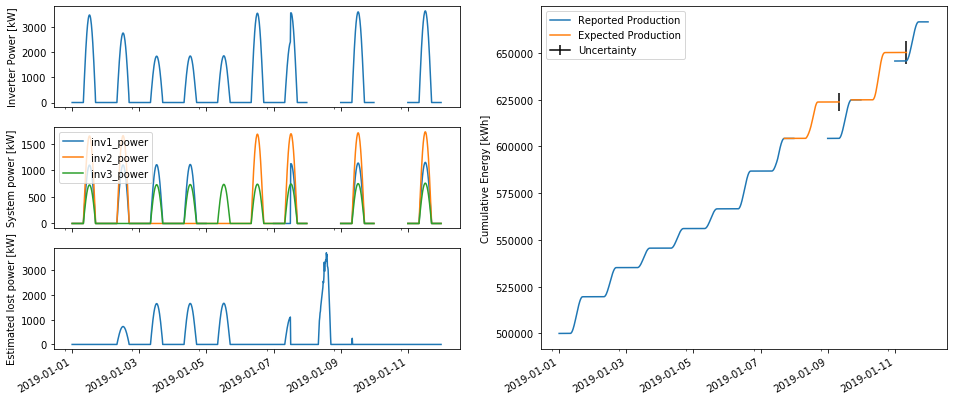

In [5]:
fig = aa.plot()
fig.set_size_inches(16, 7)
fig.axes[1].legend(loc='upper left')

Examining the plot of estimated lost power, we can see that the estimated loss is roughly in proportion to the amount of offline capacity. In particular, the loss estimate is robust to mixed outage and communication interruption like on the 5th when only the smallest inverter is reporting production but the analysis correctly inferred that one of the other inverters is producing but not communicating.

RdTools also reports rolled-up production and availability metrics:

In [6]:
pd.set_option('precision', 3)
aa.results

,lost_production,actual_production,availability
2019-01-01,0.000,19606.785,1.000
2019-01-02,4114.031,15583.450,0.791
2019-01-03,9396.788,10399.112,0.525
2019-01-04,9466.477,10476.235,0.525
2019-01-05,9522.325,10538.040,0.525
2019-01-06,0.000,20185.784,1.000
2019-01-07,2859.565,17432.736,0.859
2019-01-08,19410.396,70.982,0.004
2019-01-09,62.223,20532.285,0.997
2019-01-10,0.000,20793.015,1.000


The `AvailabilityAnalysis` object has other attributes that may be useful to inspect as well.  The `outage_info` dataframe has one row for each full system outage with several columns, perhaps the most interesting of which are `type` and `loss`.

See `AvailabilityAnalysis?` or `help(AvailabilityAnalysis)` for full descriptions of the available attributes.

In [7]:
pd.set_option('precision', 2)
# Show the first half of the dataframe
N = len(aa.outage_info.columns)
aa.outage_info.iloc[:, :N//2]

,start,end,duration,intervals,daylight_intervals,error_lower,error_upper
0,2019-01-07 17:00:00-05:00,2019-01-09 08:15:00-05:00,1 days 15:15:00,158,36,-0.23,0.24
1,2019-01-09 17:00:00-05:00,2019-01-11 08:15:00-05:00,1 days 15:15:00,158,36,-0.23,0.24


In [8]:
# Show the second half
aa.outage_info.iloc[:, N//2:]

,energy_expected,energy_start,energy_end,energy_actual,ci_lower,ci_upper,type,loss
0,19512.60,604222.14,604293.24,71.10,14940.44,24187.44,real,19441.51
1,25375.03,624825.41,645666.28,20840.87,19429.20,31454.40,comms,0.00
